In [1]:
import csv
import numpy
import random
import time

from scipy.optimize import fsolve

def deg_to_rad(degree_vals):
    return numpy.deg2rad (degree_vals)

def MollweideFunc (latitude, epsilon):
    MollweideFunc = lambda alpha : 2 * alpha + numpy.sin(2 * alpha) - numpy.pi * numpy.sin ( latitude )
        
    alpha = fsolve(MollweideFunc, latitude, xtol=epsilon)
        
    return alpha[0]
    
def GeographicToMollweide (geographicPoints):
    epsilon = 1e-6
        
    MollweidePoints = numpy.array(numpy.zeros(geographicPoints.shape))
        
    alpha = [MollweideFunc(lat, epsilon) if not numpy.isclose(numpy.absolute(lat), numpy.pi/2, rtol=epsilon, atol=0.0, equal_nan=False) else lat for lat in geographicPoints[:, 1]]
    MollweidePoints[:, 0] = (2 * numpy.sqrt(2) / numpy.pi) * ( geographicPoints[:, 0] - numpy.pi ) * numpy.cos(alpha)
    MollweidePoints[:, 1] = numpy.sqrt(2) * numpy.sin(alpha)
        
    return MollweidePoints

def geographic_to_Cartesian (points):
    new_points = numpy.zeros ( ( len(points) , 3 ) , dtype = 'float128')
    
    theta = numpy.pi / 2 - points[... , 1]
    phi = points[... , 0]
    
    new_points[...,0] = numpy.sin ( theta ) * numpy.cos ( phi )
    new_points[...,1] = numpy.sin ( theta ) * numpy.sin ( phi )
    new_points[...,2] = numpy.cos ( theta )
    
    return new_points

def tangent_geographic_to_Cartesian (points, dpoints):
    initial_vectors = numpy.array(points, dtype='float128', copy=True, order='K', subok=False, ndmin=0)
    dpoints = numpy.array(dpoints, dtype='float128', copy=True, order='K', subok=False, ndmin=0)
    
    end_vectors = initial_vectors + dpoints

    initial_vectors = geographic_to_Cartesian (initial_vectors)
    end_vectors = geographic_to_Cartesian (end_vectors)

    t = numpy.reciprocal ( numpy.einsum ( 'ij,ij->i' , initial_vectors , end_vectors ) )
    tangent_vectors = numpy.einsum ( 'ij,i->ij' , end_vectors , t ) - initial_vectors
    
    return tangent_vectors

def tangent_geographic_to_Cartesian2 (points, dpoints):
    tangent_vector = numpy.zeros ( ( len(points) , 3 ) , dtype = float)
    
    theta = numpy.pi / 2 - points[... , 1]
    phi = points[... , 0]
    
    dtheta = - dpoints[... , 1]
    dphi = dpoints[... , 0]
    
    tangent_vector[...,0] = numpy.cos (theta) * numpy.cos (phi) * dtheta - numpy.sin (theta) * numpy.sin (phi) * dphi
    tangent_vector[...,1] = numpy.cos (theta) * numpy.sin (phi) * dtheta + numpy.sin (theta) * numpy.cos (phi) * dphi
    tangent_vector[...,2] = - numpy.sin (theta) * dtheta
    
    return tangent_vector

def geographic_to_spherical (points):
    new_points = points.copy()
    
    new_points[...,0] = numpy.pi / 2 - points[...,1]
    new_points[...,1] = points[...,0]
        
    return new_points

def spherical_to_cartesian (points):
    new_points = numpy.zeros ( ( len(points) , 3 ) , dtype = float)
    
    new_points[...,0] = numpy.sin ( points[...,0] ) * numpy.cos ( points[...,1] )
    new_points[...,1] = numpy.sin ( points[...,0] ) * numpy.sin ( points[...,1] )
    new_points[...,2] = numpy.cos ( points[...,0] )
        
    return new_points

def uniform_points_on_sphere_from_data (data , N):
    starting_point_ind = random.SystemRandom().randint (1 , len(data))

    points_from_data = numpy.array([starting_point_ind])
    pairwise_distances_to_data = data.dot(data[starting_point_ind].transpose())

    for i in range(1, N):
        k = pairwise_distances_to_data.argmin()

        points_from_data = numpy.append(points_from_data, k)

        new_distances_to_data = numpy.array(data.dot(data[k].transpose()))

        pairwise_distances_to_data = numpy.maximum (pairwise_distances_to_data, new_distances_to_data)
        
    return (points_from_data)

def switch_hemispheres_geographic_coords (points):
    new_points = points.copy()
    
    new_points[...,0] = numpy.where ( points[...,0] < numpy.pi , points[...,0] + numpy.pi , points[...,0] - numpy.pi )
    
    return new_points

def simple_input_func (path):
    points = []
    
    with open(path) as csvfile:
        reader = csv.reader ( csvfile )
        next ( reader )
        
        for row in reader:
            ra = numpy.deg2rad ( float ( row[5] ) )
            dec = numpy.deg2rad ( float ( row[7] ) )
            
            points.append ( [ ra , dec ] )
    
    points = numpy.array ( points )
    return points

def simple_input_func_pm (path):
    points = []
    
    with open(path) as csvfile:
        reader = csv.reader ( csvfile )
        next ( reader )
        
        for row in reader:
            if row[12] == "NULL":
                ra = numpy.nan
            else:
                print(row[12])
                ra = numpy.deg2rad ( float ( row[12] ) )
                
            if row[14] == "NULL":
                dec = numpy.nan
            else:
                dec = numpy.deg2rad ( float ( row[14] ) )
            
            points.append ( [ ra , dec ] )
    
    points = numpy.array ( points )
    return points

# Data import

In [7]:
import pandas
import numpy

class AstrometricDataframe:
    def __init__(self): 
        self.positions = numpy.array ([])
        self.positions_coord_system = ""

        self.positions_err = numpy.array ([])

        self.proper_motions = numpy.array ([])

        self.proper_motions_err = numpy.array ([])
        
        self.proper_motions_err_corr = numpy.array ([])
    
#     def change_positions_to_Cartesian (self):
#         self.positions = geographic_to_Cartesian(self.positions)
        
#     def change_to_rad (self):
#         self.positions = deg_to_rad(self.positions)
    

def import_Gaia_data (path_to_Gaia_data):
    dataset = pandas.read_csv(path_to_Gaia_data,
                              sep=',',
                              delimiter=None,
                              header='infer',
                              names=None,
                              index_col=None,
                              usecols=None,
                              squeeze=False,
                              prefix=None,
                              mangle_dupe_cols=True,
                              dtype=None,
                              engine='python',
                              converters=None,
                              true_values=None,
                              false_values=None,
                              skipinitialspace=False,
                              skiprows=None,
                              skipfooter=0,
                              nrows=None,
                              na_values=None,
                              keep_default_na=True,
                              na_filter=True,
                              verbose=False,
                              skip_blank_lines=True,
                              parse_dates=False,
                              infer_datetime_format=False,
                              keep_date_col=False,
                              date_parser=None,
                              dayfirst=False,
                              iterator=False,
                              chunksize=None,
                              compression=None,
                              thousands=None,
                              decimal=b'.',
                              lineterminator=None,
                              quotechar='"',
                              quoting=0,
                              doublequote=True,
                              escapechar=None,
                              comment=None,
                              encoding=None,
                              dialect=None,
                              error_bad_lines=True,
                              warn_bad_lines=True,
                              delim_whitespace=False,
                              low_memory=True,
                              memory_map=False,
                              float_precision=None)
    
    dropna_columns = ['ra',
                     'dec',
                     'ra_error',
                     'dec_error',
                     'pmra',
                     'pmdec',
                     'pmra_error',
                     'pmdec_error',
                     'pmra_pmdec_corr']

    dataset.dropna(axis=0,
                   how='any',
                   thresh=None,
                   subset=dropna_columns,
                   inplace=True)
    
    new_dataframe = AstrometricDataframe()
    
    new_dataframe.positions = dataset.as_matrix ( columns = [ 'ra' , 'dec' ] )
    new_dataframe.positions_coord_system = "Geographic"
    
    new_dataframe.positions_err = dataset.as_matrix ( columns = [ 'ra_error' , 'dec_error' ] )
    
    new_dataframe.proper_motions = dataset.as_matrix ( columns = [ 'pmra' , 'pmdec' ] )
    
    new_dataframe.proper_motions_err = dataset.as_matrix ( columns = [ 'pmra_error' , 'pmdec_error' ] )
    
    new_dataframe.proper_motions_err_corr = dataset.as_matrix ( columns = [ 'pmra_pmdec_corr' ] )
    
    return new_dataframe
    

In [8]:
data3 = import_Gaia_data("data/type2.csv")

# Data conversion and coordinates change

In [15]:
# Change positions from deg to rad

data3.positions = deg_to_rad (data3.positions)

In [16]:
# Change proper motions from mas/yr to rad/s

data3.proper_motions = data3.proper_motions * 1.5362818500441604e-16
data3.proper_motions_err = data3.proper_motions_err * 1.5362818500441604e-16

In [518]:
# Change proper motions from (ra,dec) to Cartesian coordinates

data3.proper_motions = tangent_geographic_to_Cartesian2 (data3.positions , data3.proper_motions)
data3.proper_motions_err = tangent_geographic_to_Cartesian2 (data3.positions , data3.proper_motions_err)

In [519]:
# Change positions from (ra,dec) to Cartesian

data3.positions = geographic_to_Cartesian (data3.positions)

In [263]:
initial_pos = type3_sample
final_pos = type3_sample + type3_sample_pm

lines_to_plot = []

for i,_ in enumerate (initial_pos):
    longs = numpy.linspace(initial_pos[i,0], final_pos[i,0], 10)
    lats = numpy.linspace(initial_pos[i,1], final_pos[i,1], 10)
    
    line_m = GeographicToMollweide ( numpy.array ( [longs , lats] ).transpose() )
    
    lines_to_plot.append( line_m.transpose() )


In [28]:
data3.proper_motions_err_corr

def tangent_err_to_Cartesrian (positions , pms , pm_errs , pm_err_corr):
    for i , point in enumerate (positions):
        ra = point[0]
        dec = point[1]
        
        pmra_err = pm_errs[i,0]
        pmdec_err = pm_errs[i,1]
        
        pmra_pmdec_err_corr = pm_err_corr[i,0]
        
        R = numpy.array ( [ [ - numpy.cos ( dec ) * numpy.sin ( ra ) , - numpy.sin ( dec ) * numpy.cos ( ra ) ] ,
                            [ numpy.cos ( dec) * numpy.sin ( ra ) , - numpy.sin ( dec ) * numpy.sin ( ra ) ] ,
                            [ - numpy.cos ( dec ) , 0 ] ] )
        
        pm_err_matrix = numpy.array ( [ [ pmra_err , numpy.sqrt ( numpy.abs (pmra_err * pmdec_err * pmra_pmdec_err_corr ) ) ] ,
                                        [ numpy.sqrt ( numpy.abs (pmra_err * pmdec_err * pmra_pmdec_err_corr ) ) , pmdec_err ] ] )
        
        pm_err_matrix_Cartesian = R.dot(pm_err_matrix).dot(R.transpose())
        
#         print (numpy.linalg.eig(pm_err_matrix_Cartesian))
    
tangent_err_to_Cartesrian (data3.positions , data3.proper_motions , data3.proper_motions_err , data3.proper_motions_err_corr)

1.23178108457e-33 8.36881479529e-33 5.55374077201e-17
-82.0678216781


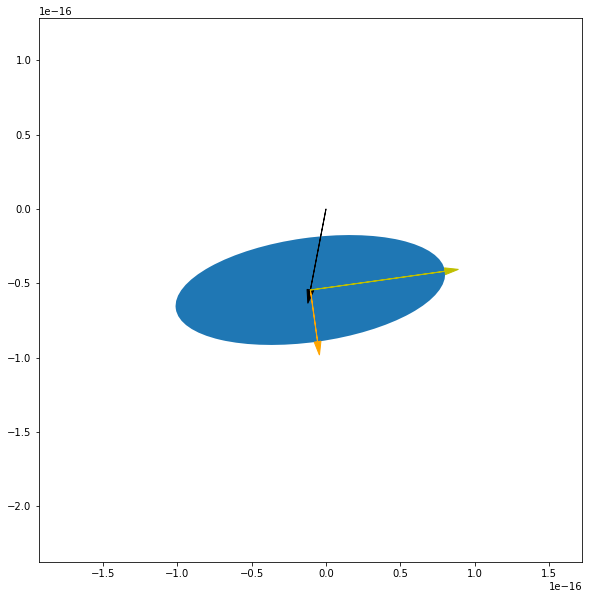

[[  8.23289553e-33  -9.75492880e-34]
 [ -9.75492880e-34   1.36770035e-33]]


In [223]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_pm_err_ellipse (pm , pm_err , pm_err_corr):
    i = 575
    
    covariance_matrix = numpy.array ( [ [ pm_err[i,0] * pm_err[i,0] , pm_err_corr[i] * pm_err[i,0] * pm_err[i,1] ],
                                        [ pm_err_corr[i] * pm_err[i,1] * pm_err[i,0] , pm_err[i,1] * pm_err[i,1] ] ] )
    
    eigenvalues , eigenvectors = numpy.linalg.eig ( covariance_matrix )
    
    box_size = numpy.max ( [ numpy.sqrt(eigenvalues[0]) , numpy.sqrt(eigenvalues[1]) , numpy.linalg.norm ( pm[i] ) ] )
    
    print (eigenvalues[0] , eigenvalues[1] , numpy.linalg.norm ( pm[i] ))

    plt.figure(figsize=(10,10))
    plt.axes().set_aspect('equal')
    ax = plt.gca()
    
    plt.xlim ( [ pm[i,0] - 2 * box_size , pm[i,0] + 2 * box_size ] )
    plt.ylim ( [ pm[i,1] - 2 * box_size , pm[i,1] + 2 * box_size ] )
    
    plt.arrow(0 , 0 , pm[i,0] , pm[i,1] , width=box_size * 1e-3 , head_width=box_size * 0.5e-1, head_length=box_size * 1e-1 , color='k')
            
    plt.arrow(pm[i,0] , pm[i,1] , numpy.sqrt(eigenvalues[0]) * eigenvectors[0,0] , numpy.sqrt(eigenvalues[0]) * eigenvectors[0,1] , width=box_size * 1e-3 , head_width=box_size * 0.5e-1, head_length=box_size * 1e-1 , color='orange')
    
    plt.arrow(pm[i,0] , pm[i,1] , numpy.sqrt(eigenvalues[1]) * eigenvectors[1,0] , numpy.sqrt(eigenvalues[1]) * eigenvectors[1,1] , width=box_size * 1e-3 , head_width=box_size * 0.5e-1, head_length=box_size * 1e-1 , color='y')
    
    angle = - numpy.rad2deg ( numpy.arctan2 ( eigenvectors[1,0] , eigenvectors[1,1] ) )
    
    print (angle)
        
    ell = Ellipse(xy=(pm[i,0] , pm[i,1]), width=2 * numpy.sqrt(eigenvalues[0]), height=2 * numpy.sqrt(eigenvalues[1]), angle = angle)
    
    ax.add_patch(ell)
    ax.set_aspect('equal')
            
    plt.show()
    
    return covariance_matrix

print (plot_pm_err_ellipse ( data3.proper_motions , data3.proper_motions_err , data3.proper_motions_err_corr ))

In [36]:
# calculate the covariance between two variables
from numpy.random import randn
from numpy.random import seed
from numpy import cov
# seed random number generator
seed(1)
# prepare data
data1 = 20 * randn(1000) + 100
data2 = data1 + (10 * randn(1000) + 50)
# calculate covariance matrix
covariance = cov(data1, data2)
print(covariance)

[[ 385.33297729  389.7545618 ]
 [ 389.7545618   500.38006058]]


In [267]:
initial_pos_m = GeographicToMollweide ( initial_pos )
final_pos_m = GeographicToMollweide ( final_pos )
diff_m = final_pos_m - initial_pos_m

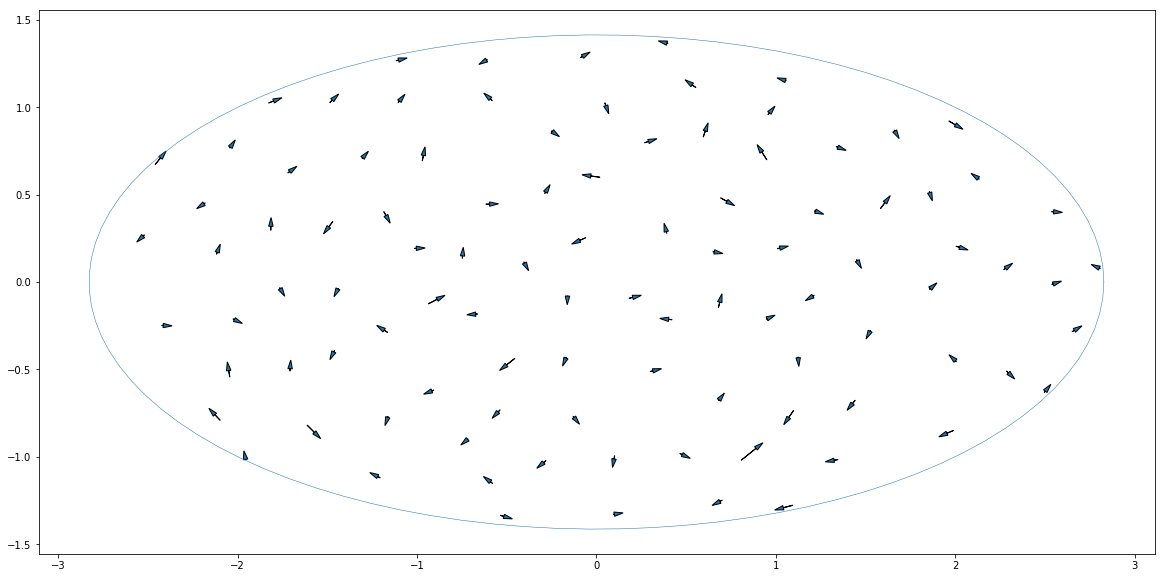

In [279]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

t = numpy.linspace (0, 2 * numpy.pi, 100)
plt.plot ( 2 * numpy.sqrt(2) * numpy.cos(t) , numpy.sqrt(2) * numpy.sin(t) , linewidth=0.5 )

for i,_ in enumerate(initial_pos_m):
    plt.arrow( initial_pos_m[i,0] , initial_pos_m[i,1] , diff_m[i,0] , diff_m[i,1] , head_width=0.025, head_length=0.05)

plt.show()

ScalarCoefs(nmax = 4, mmax = 4):
n = 0 :: [(0.28957779116891552+0.0029902766513857553j)]
n = 1 :: [(1.5827371864025106+0.59914203423598256j), (0.76079213589028694-0.36584972097461582j), (0.31858739517369128-0.90658380719575726j)]
n = 2 :: [(1.053021771585972+1.7987699229335334j), (-0.23655984188406579+0.98097625969583135j), (-1.4352712361770228+1.3023050697673006j), (-0.71497065784804592+0.63931763708886347j), (-1.5690584287014415+2.0358972252559893j)]
n = 3 :: [(-1.0264996593401143-0.1164659709719716j), (0.40896038928044581-0.46138839416631239j), (-0.19674446522949046+0.42384303977553717j), (0.66887250419953515+1.6360241592259701j), (-2.6235619523133016-1.1898231829897614j), (-0.034704417351920654+1.3834885989416845j), (0.50939519249559972-1.1565586834637172j)]
n = 4 :: [(0.83686156004826739-0.95851021420743698j), (2.3560564958900825+0.038375422402337815j), (1.3484005167356456+1.1420715355515594j), (-1.5659806966080487+1.0151109068705091j), (-0.071415503607576217+0.11342729804484047j)

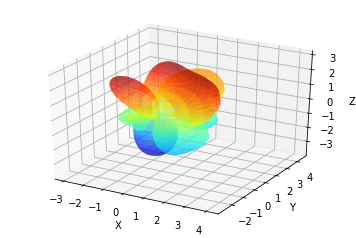

In [50]:
import spherepy as sp
c = sp.random_coefs(4, 4) # generate some random coefficients
print (c)
sp.pretty_coefs(c)
p = sp.ispht(c, 50, 50) # inverse spherical transform to pattern
sp.plot_sphere_mag(p) # plot the magnitude of the pattern

In [296]:
diff_m.argmin(axis=0)

array([20, 71])

In [ ]:
# look up units